In [7]:
# from aerobot.plot import plot_training_curve
import os
from aerobot.io import load_results_dict, RESULTS_PATH, FEATURE_SUBTYPES, FEATURE_TYPES
import matplotlib.pyplot as plt
from aerobot.plot import plot_configure_mpl, plot_model_accuracy_barplot, plot_order_feature_types, plot_percent_above_random_axis
from matplotlib.gridspec import GridSpec
from aerobot.dataset import dataset_load_training_validation
import pandas as pd 
import numpy as np 
from typing import Dict, List

%load_ext autoreload
%autoreload 2

plot_configure_mpl(figure_height=2.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load the model training results. 
nonlinear_results_ternary = dict()
logistic_results_ternary = dict()
logistic_results_binary = dict()

for feature_type in FEATURE_SUBTYPES + FEATURE_TYPES:
    nonlinear_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_nonlinear_{feature_type}_ternary.json'))
    logistic_results_ternary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_ternary.json'))
    logistic_results_binary[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, f'train_logistic_{feature_type}_binary.json'))

for results_type, results in zip(['Nonlinear ternary', 'Logistic binary', 'Logistic ternary'], [nonlinear_results_ternary, logistic_results_ternary, logistic_results_binary]):
    print(results_type, 'results')
    for feature_type, feature_type_results in results.items():
        val_acc = feature_type_results['validation_acc']
        train_acc = feature_type_results['training_acc']
        print(f'\t{feature_type}:', f'val_acc={val_acc}, train_acc={train_acc}')

    print()

Nonlinear ternary results
	metadata.number_of_genes: val_acc=0.49583282687183045, train_acc=0.4958388771114068
	metadata.oxygen_genes: val_acc=0.595400084092316, train_acc=0.6023595855397743
	metadata.pct_oxygen_genes: val_acc=0.6367256085381291, train_acc=0.6106437568234447
	KO: val_acc=0.7945235627962602, train_acc=0.9713804791228355
	embedding.genome: val_acc=0.8236612192692165, train_acc=0.8712617377213
	embedding.geneset.oxygen: val_acc=0.785176419022573, train_acc=0.9274938009969587
	metadata: val_acc=0.7447854960146012, train_acc=0.7078733819786587
	chemical: val_acc=0.6738431004967449, train_acc=0.6865747690907171
	nt_1mer: val_acc=0.4513395729390486, train_acc=0.4605023237952736
	nt_2mer: val_acc=0.6275817121441507, train_acc=0.6174217307577384
	nt_3mer: val_acc=0.7607944091064379, train_acc=0.773679310926306
	nt_4mer: val_acc=0.7869398043111581, train_acc=0.8621779086758913
	nt_5mer: val_acc=0.7908581215693639, train_acc=0.9026093089188953
	cds_1mer: val_acc=0.515761949062506

# SI Figure 2 



In [9]:
def plot_si_figure_2a(logistic_results_binary:Dict, grid:GridSpec=None, fig:plt.Figure=None):  
    '''Plots a barplot showing the final training and validation accuracies of the binary Logistic classifier.'''
    ax = fig.add_subplot(grid)
    
    ax.set_title('Logistic binary classifier')
    plot_percent_above_random_axis(ax, binary=True)

    order_by = {f:r['validation_acc'] for f, r in logistic_results_binary.items()}
    feature_type_order = plot_order_feature_types(list(logistic_results_binary.keys()), order_by=order_by)

    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_binary, ax=ax, feature_type_order=feature_type_order)

    return ax

In [10]:
def plot_si_figure_2b(logistic_results_ternary:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plots a barplot showing the final training and validation accuracies of the ternary Logistic classifier.'''
    ax = fig.add_subplot(grid)

    ax.set_title('Logistic ternary classifier')
    plot_percent_above_random_axis(ax, binary=False)

    order_by = {f:r['validation_acc'] for f, r in logistic_results_ternary.items()}
    feature_type_order = plot_order_feature_types(list(logistic_results_ternary.keys()), order_by=order_by)

    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(logistic_results_ternary, ax=ax, feature_type_order=feature_type_order)

    return ax

In [11]:
def plot_si_figure_2c(nonlinear_results_ternary:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plots a barplot showing the final training and validation accuracies of the ternary Nonlinear classifier.'''
    ax = fig.add_subplot(grid)

    ax.set_title('Nonlinear ternary classifier')
    plot_percent_above_random_axis(ax, binary=False)

    order_by = {f:r['validation_acc'] for f, r in nonlinear_results_ternary.items()}
    feature_type_order = plot_order_feature_types(list(nonlinear_results_ternary.keys()), order_by=order_by)

    # Might be good to sort features on the bar plot according to validation accuracy. 
    plot_model_accuracy_barplot(nonlinear_results_ternary, ax=ax, feature_type_order=feature_type_order)
    
    return ax

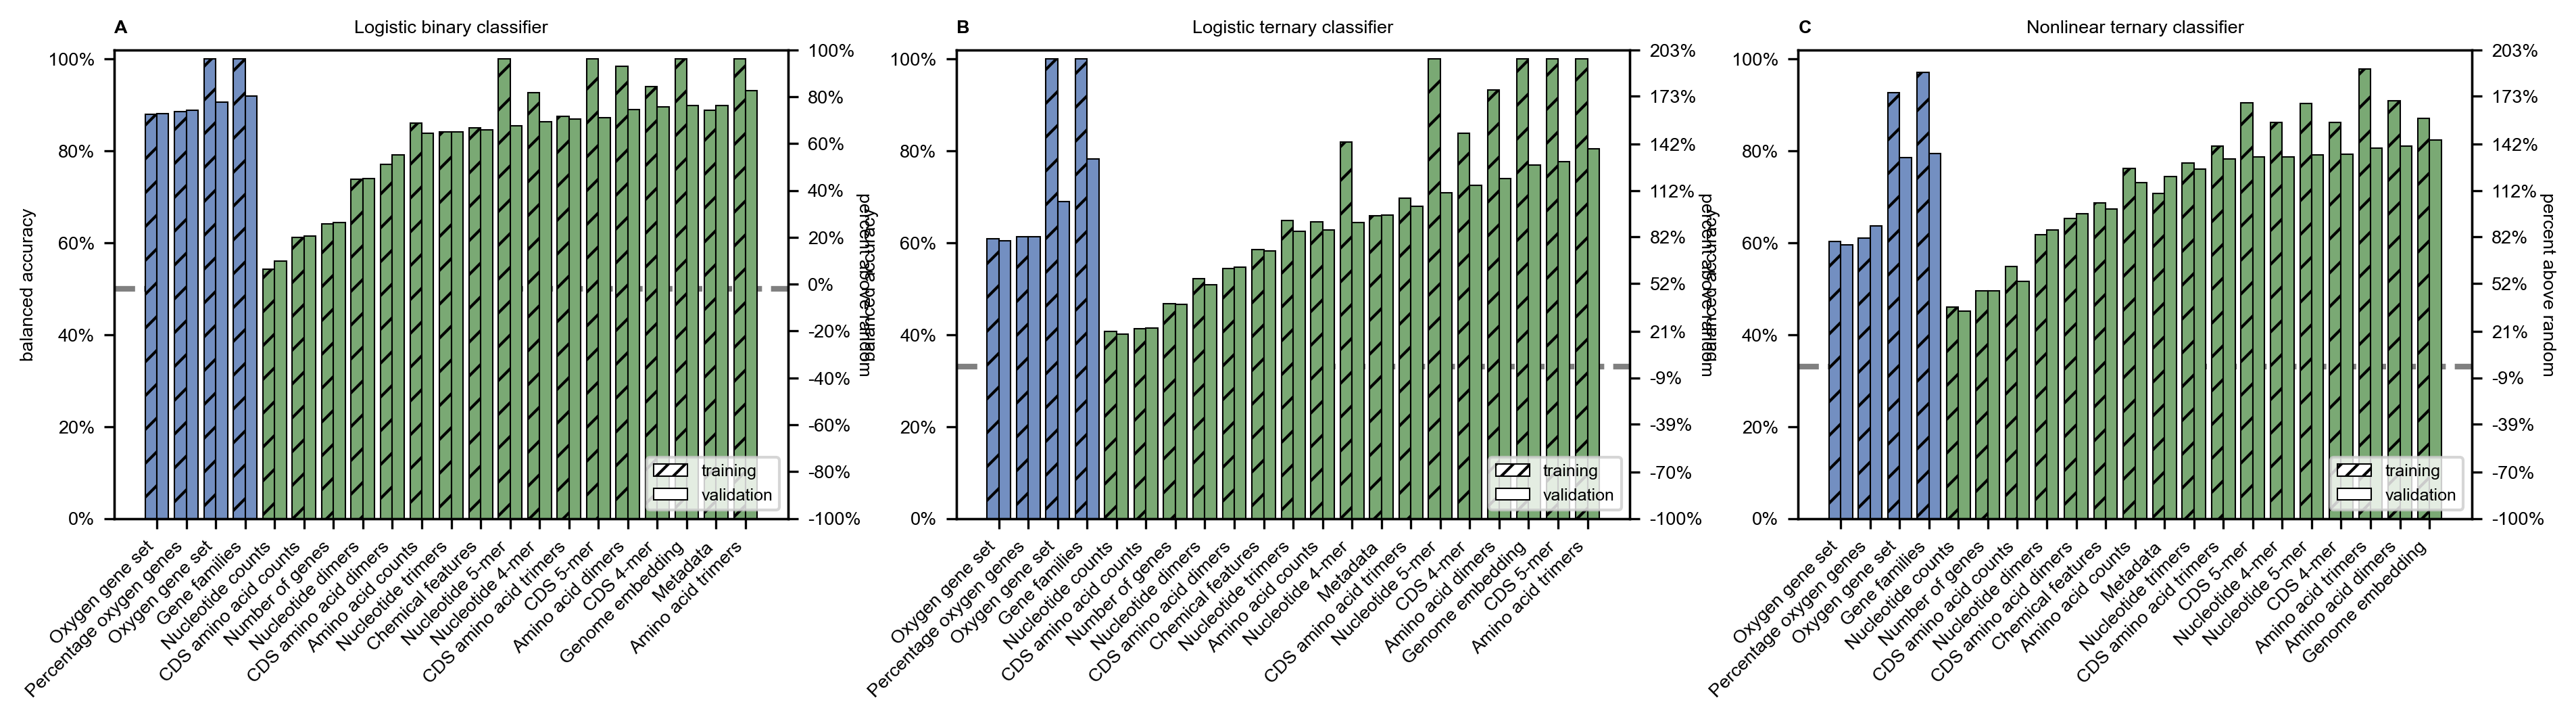

In [12]:
fig = plt.figure(figsize=(15, 3))
grid = GridSpec(1, 3, wspace=0.25)

axes = []
axes.append(plot_si_figure_2a(logistic_results_binary, grid=grid[0, 0], fig=fig))
axes.append(plot_si_figure_2b(logistic_results_ternary, grid=grid[0, 1], fig=fig))
axes.append(plot_si_figure_2c(nonlinear_results_ternary, grid=grid[0, 2], fig=fig))

for ax, ax_label in zip(axes, 'ABC'):
    ax.set_title(ax_label, loc='left', fontweight='bold')

plt.savefig('../results/figures/si_fig2.png', dpi=300, facecolor='w', bbox_inches='tight')
plt.show()
